# Machine Learning for Optical Network Security Monitoring: A Practical Perspective

This file contains the implementation of the Window-based Attack Detection (WAD) approach for security diagnostics reported in Sec. III.A of the paper.

Paper available at IEEE Xplore: https://doi.org/10.1109/JLT.2020.2987032.

Notation:
- $T_N$: True negative rate.
- $F_P$: False positive rate.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # This import registers the 3D projection, but is otherwise unused.
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# definitions for the plots
color_map = cm.coolwarm
fig_size = (12, 5)

In [2]:
def get_probabilities(tnr, fpr, tpr, fnr, delta, gamma, tau):
    true_probability = .0
    false_probability = .0
    
    for l in range(0, delta-gamma+1):
        sum_negatives = .0
        sum_positives = .0
        if l <= tau:
            fact = math.factorial(delta-gamma) / (math.factorial(l) * math.factorial(delta - gamma - l))
            prob_fp = fpr ** l
            prob_tn = tnr ** (delta - gamma - l)
            sum_negatives = sum_negatives + fact * prob_fp * prob_tn
            
            for k in range(tau - l, gamma+1):
                fact = math.factorial(gamma) / (math.factorial(k) * math.factorial(gamma - k))
                prob_tp = tpr ** k
                prob_fn = fnr ** (gamma - k)
                sum_positives += fact * prob_tp * prob_fn
            
            true_probability += sum_negatives * sum_positives
            
        else:
            fact = math.factorial(delta - gamma) / (math.factorial(l) * math.factorial(delta - gamma - l))
            prob_fp = fpr ** l
            prob_tn = tnr ** (delta - gamma - l)
            sum_negatives += fact * prob_fp * prob_tn
            
            for k in range(0, gamma+1):
                fact = math.factorial(gamma) / (math.factorial(k) * math.factorial(gamma - k))
                prob_tp = tpr ** k
                prob_fn = fnr ** (gamma - k)
                sum_positives += fact * prob_tp * prob_fn
                
            true_probability += sum_negatives * sum_positives
            
        if l >= tau:
            fact = math.factorial(delta) / (math.factorial(l) * math.factorial(delta - l))
            prob_fp = fpr ** l
            prob_tn = tnr ** (delta - l)
            false_probability += fact * prob_fp * prob_tn
    
    return true_probability, false_probability

## Alarm probability over time

Plots used in Fig. 13, Sec. VII of the paper.

In [3]:
fpr = 0.0179
fnr = 0.053766666666666664
tpr = 1 - fnr
tnr = 1 - fpr

deltas = [x for x in range(10, 41, 10)]
taus = [x for x in range(1, 11, 2)]

total_time = max(deltas) * 2

results = np.zeros((len(deltas), len(taus), total_time*2+1))

for d, delta in enumerate(deltas):
    for t, tau in enumerate(taus):
        for time in range(-total_time, total_time+1):
            if time <= 0:
                gamma = 0
                true_probability, false_probability = get_probabilities(tnr, fpr, tpr, fnr, delta, gamma, tau)
                results[d, t, time+total_time] = false_probability
            else:
                if time >= delta:
                    gamma = delta
                else:
                    gamma = time
                true_probability, false_probability = get_probabilities(tnr, fpr, tpr, fnr, delta, gamma, tau)
                results[d, t, time+total_time] = true_probability

In [4]:
line_styles = ['-.', '--', ':', '-']
colors = [
    [0.00,0.45,0.74],
    [0.93,0.69,0.13],
    [0.49,0.18,0.56],
    [0.47,0.67,0.19],
    [0.85,0.33,0.10]
]

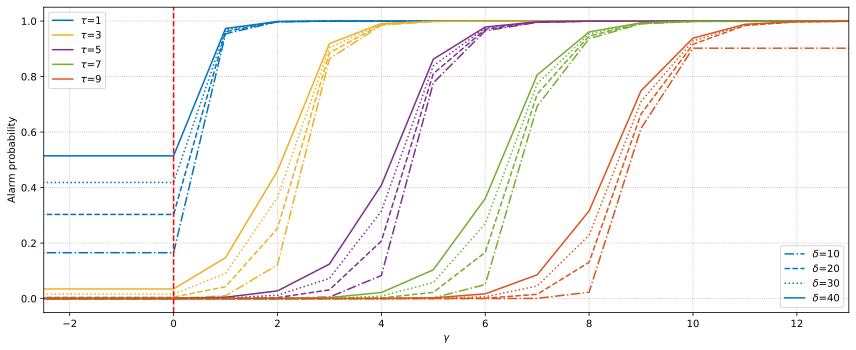

In [5]:
plt.figure(figsize=fig_size)

handles_deltas = []
handles_taus = []

for d, delta in enumerate(deltas):
    for t, tau in enumerate(taus):
        h, = plt.plot(range(-total_time, total_time+1), results[d, t, :], linestyle=line_styles[d], color=colors[t])
        if t == 0:
            handles_deltas.append(h)
        if d == 3:
            handles_taus.append(h)

plt.axvline(0, color='red', linestyle='--')
plt.xlabel('$\gamma$')
plt.ylabel('Alarm probability')
plt.xlim([-2.5, 13])
plt.grid(linestyle=':')

first_legend = plt.legend(handles_taus, [r'$\tau$='+str(tau) for tau in taus], loc=2)
plt.gca().add_artist(first_legend)
plt.legend(handles_deltas, [r'$\delta$='+str(delta) for delta in deltas], loc=4)

plt.tight_layout()
plt.show()